In [ ]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import vgg16, VGG16_Weights
import torch.optim as optim
from torchvision import transforms
from pycocotools.coco import COCO
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
# from google.colab import drive
import skimage.io as io

/home/alejandro/Sync/Computer_Engineering/Deep_Learning/Image2Text-UPF/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# cd "/content/drive/MyDrive/DeepLearning/Final Project/src"

/content/drive/MyDrive/DeepLearning/Final Project/src


In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = models.vgg16(weights=VGG16_Weights.DEFAULT).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x



class CaptionGenerator(nn.Module):
    def __init__(self):
        super(CaptionGenerator, self).__init__()
        self.vgg = VGG()
        self.fc = nn.Linear(25088, 768) # TODO: try not to hard code
        
        self.gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt2_model.config.add_cross_attention = True
        # self.gpt2_model.config.return_dict = False

    def forward(self, images, captions, tokenizer):
        # Step 1: Extract image features using VGG
        image_features = self.vgg(images)

        prediction_outputs = []
        for image_feature, caption in zip(image_features, captions):
            # Step 2: Tokenize captions and prepare input tensors
            # caption = self.gpt2_tokenizer(caption, return_tensors="pt")
            embeds = self.gpt2_model.transformer.wte.weight[caption, :]
            # Step 3: Pass image features through a feed-forward network to get a format suitable for GPT-2
            # Note: You might need to adjust the dimensions and other details according to your implementation.
            image_feature = self.fc(image_feature)

            # Step 4: Combine image features and caption tokens
            # We add the image features at the start of each sequence (assuming image_features are tensors of the appropriate size)
            
            embeds = torch.cat((image_feature.unsqueeze(0).unsqueeze(0), embeds), dim=1)

            # Step 5: Forward pass through GPT-2 model
            outputs = self.gpt2_model(inputs_embeds = embeds)
            predicted_token_ids = torch.argmax(outputs.logits, dim=-1)
            prediction_outputs.append(predicted_token_ids)
            #print(tokenizer.decode(predicted_token_ids[0]))
            

        
        return prediction_outputs


class CocoDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(captions_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transform = transform
        # self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]
        
        url = image_info["coco_url"]
        # image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.fromarray(io.imread(url))

        # image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption_ids = self.coco.getAnnIds(image_id)
        caption = [self.coco.anns[cid]['caption'] for cid in caption_ids]
        caption = self.coco.anns[caption_ids[0]]['caption']
        # caption = self.gpt2_tokenizer(caption, return_tensors="pt")
        
        return image, caption

In [ ]:
# Define the transformation to be applied to each image
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image
])


train_image_dir = "../data/cocoapi/images/train2014"
train_captions_file = "../data/cocoapi/annotations/captions_train2014.json"
train_dataset = CocoDataset(train_image_dir, train_captions_file, transform=image_transform)

val_image_dir = "../data/cocoapi/images/val2014"
val_captions_file = "../data/cocoapi/annotations/captions_val2014.json"
val_dataset = CocoDataset(val_image_dir, val_captions_file, transform=image_transform)


batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



loading annotations into memory...
Done (t=1.55s)
creating index...
index created!
loading annotations into memory...
Done (t=1.30s)
creating index...
index created!


A large and small dog siting in the back seat of a car


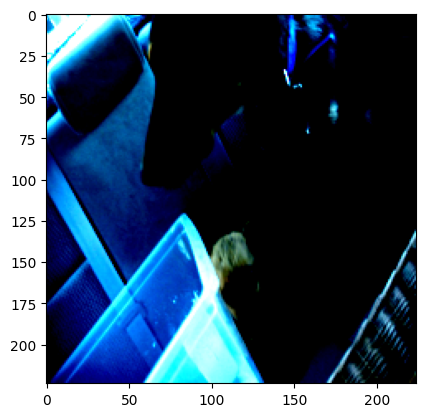

In [ ]:
samples = np.random.choice(len(train_dataset), size=2, replace=False)
image1, caption_inputs1 = train_dataset[samples[0]]
image2, caption_inputs2 = train_dataset[samples[1]]

# print(caption_inputs1[0])
# print(train_dataset.tokenizer.encode(caption_inputs1[0]))
# print(caption_inputs2)

# Convert the tensor images to numpy arrays
image1 = image1.permute(1, 2, 0).numpy()
image2 = image2.permute(1, 2, 0).numpy()

# # Decode the tokenized captions
# captions1 = [train_dataset.tokenizer.decode(token_ids) for token_ids in caption_inputs1.input_ids]
# # captions2 = [train_dataset.tokenizer.decode(token_ids) for token_ids in caption_inputs2.input_ids]

# # Plot the images with their captions
plt.imshow(image1)
print(caption_inputs1)

In [ ]:

# plt.show()

# Instantiate the pre-trained models
cnn_backbone = vgg16(weights=VGG16_Weights.DEFAULT).to("cuda")
language_model = GPT2LMHeadModel.from_pretrained('gpt2').to("cuda")

# Freeze the parameters of the CNN backbone
for param in cnn_backbone.parameters():
    param.requires_grad = False


# Create an instance of the Image Captioning model
caption_generator = CaptionGenerator().to("cuda")

# Set up the optimizer and loss function
learning_rate = 0.001
optimizer = optim.Adam(caption_generator.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 1000



# Main code
caption_generator.train()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})



0

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for images, captions in train_data_loader:
        optimizer.zero_grad()
        caption_tokens = [tokenizer(caption, return_tensors="pt").input_ids.to("cuda") for caption in captions ]
        outputs = caption_generator(images.to("cuda"), caption_tokens, tokenizer)
        batch_loss = 0
        for caption_input, caption_output in zip(caption_tokens, outputs):
            caption_input = caption_input.type(torch.float)
            caption_input.requires_grad_()
            caption_output = caption_output.type(torch.float)
            caption_output.requires_grad_()
            
            # Determine the difference in dimensions
            dim_diff = abs(caption_input.shape[1] - caption_output.shape[1])
            if (caption_input.shape[1] < caption_output.shape[1]):
                caption_input = nn.functional.pad(caption_input, (0, dim_diff))
            elif (caption_input.shape[1] > caption_output.shape[1]):
                caption_output = nn.functional.pad(caption_output, (0, dim_diff))

            loss = criterion(caption_output, caption_input)
            batch_loss += loss

            loss.backward()
            optimizer.step()
        print(f"Batch loss : {batch_loss/len(captions)}")

# Inference



Batch loss : 295472064.0
Batch loss : 218333168.0
Batch loss : 263338336.0
Batch loss : 588804992.0
Batch loss : 298899232.0
Batch loss : 376973216.0
Batch loss : 408749696.0
Batch loss : 264261568.0
Batch loss : 292605184.0
Batch loss : 260803104.0
Batch loss : 177852464.0
Batch loss : 336638816.0
Batch loss : 401404512.0
Batch loss : 179281520.0
Batch loss : 205500896.0
Batch loss : 545362688.0
Batch loss : 421745312.0
Batch loss : 226383584.0
Batch loss : 301229088.0
Batch loss : 294850528.0
Batch loss : 404615200.0
Batch loss : 424024896.0
Batch loss : 258623936.0
Batch loss : 129911520.0
Batch loss : 147687712.0
Batch loss : 230331072.0
Batch loss : 522586944.0
Batch loss : 418404608.0
Batch loss : 273790816.0
Batch loss : 207738512.0
Batch loss : 244968272.0
Batch loss : 252839760.0
Batch loss : 213412112.0
Batch loss : 225011840.0
Batch loss : 302182272.0
Batch loss : 435206336.0
Batch loss : 143515216.0


RuntimeError: ignored